In [29]:
import yaml
import numpy as np
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torch.utils.data.dataloader import DataLoader

from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression

from models.resnet_base_network import ResNet18Base
from data.transforms import get_simclr_data_transforms_test

In [2]:
config = yaml.load(open("./config/config.yaml", "r"), Loader=yaml.FullLoader)
byol_config = yaml.load(open("./config/byol_config.yaml", "r"), Loader=yaml.FullLoader)

In [41]:
# weights_path = Path('runs/Dec21_03-30-50_hub/checkpoints/model.pth') #100 epochs
weights_path = Path('runs/Dec21_01-49-28_hub/checkpoints/model.pth') # 40 epochs

weights_full = torch.load(weights_path)

In [42]:
online_network = ResNet18Base(**config['network']).to('cuda')
online_network.load_state_dict(weights_full['online_network_state_dict'])

/homes/evgenya/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/homes/evgenya/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [43]:
data_transform_identity = get_simclr_data_transforms_test('mnist')

train_dataset = datasets.MNIST(
    '~/skoltech/datasets/', download=True,
    transform=data_transform_identity, train=True
) 
test_dataset = datasets.MNIST(
    '~/skoltech/datasets/', download=True,
    transform=data_transform_identity, train=False
) 

In [12]:
test_loader = DataLoader(test_dataset, batch_size=128, num_workers=4, drop_last=False, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=4, drop_last=False, shuffle=True)

In [14]:
embeddings, gt_labels = [], []

for images, labels in tqdm(test_loader):
    output = online_network(images.to('cuda'))
    embeddings.extend(output.detach().cpu().numpy())
    gt_labels.extend(labels.numpy())

  0%|          | 0/79 [00:00<?, ?it/s]

In [16]:
tsne = TSNE()
x_2d = tsne.fit_transform(np.array(embeddings))

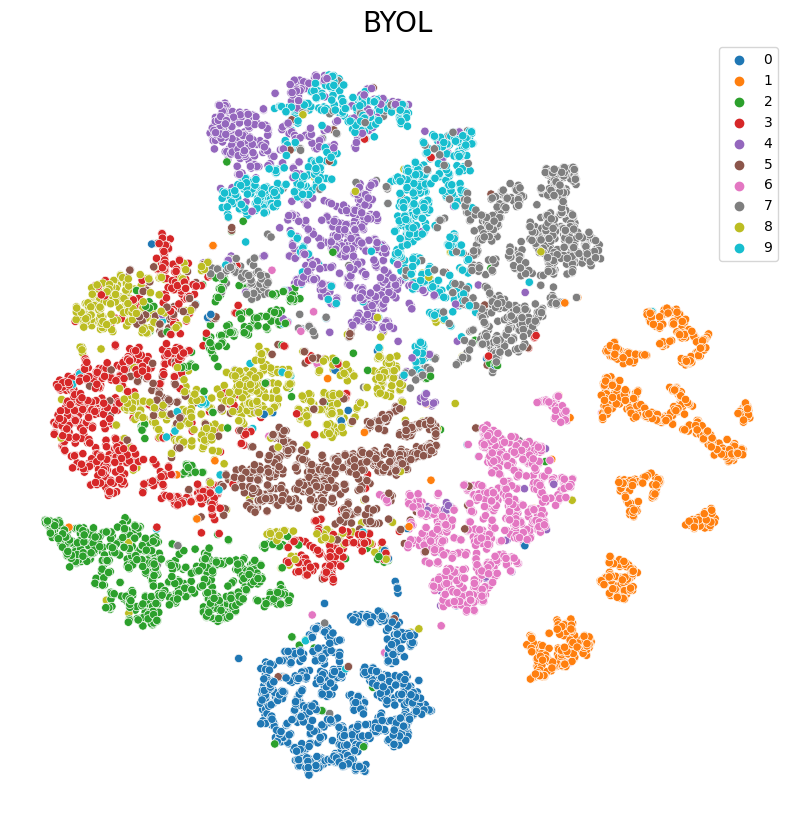

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(
    x=x_2d[:, 0],
    y=x_2d[:, 1],
    hue=map(str, gt_labels),
    hue_order=[str(i) for i in range(10)],
    # legend=None,
    # size=3,
)
plt.title('BYOL', size=20)
plt.axis('off');

In [44]:
embeddings, gt_labels = [], []

for images, labels in tqdm(train_loader):
    output = online_network(images.to('cuda'))
    embeddings.extend(output.detach().cpu().numpy())
    gt_labels.extend(labels.numpy())

  0%|          | 0/469 [00:00<?, ?it/s]

In [45]:
X = np.array(embeddings)
y = np.array(gt_labels)

In [46]:
logreg = LogisticRegression(random_state=0).fit(X, y)

/homes/evgenya/miniconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [47]:
embeddings, gt_labels = [], []

for images, labels in tqdm(test_loader):
    output = online_network(images.to('cuda'))
    embeddings.extend(output.detach().cpu().numpy())
    gt_labels.extend(labels.numpy())
    
test_X = np.array(embeddings)
test_y = np.array(gt_labels)

  0%|          | 0/79 [00:00<?, ?it/s]

In [48]:
logreg.score(test_X, test_y)

0.917